In [1]:
import sympy as sp
from sympy.vector import CoordSys3D
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import matplotlib.animation as animation

sp.init_printing()

from matplotlib import rc
rc('animation', html='jshtml', embed_limit=500)
#animation.

# Code from the previous notebook

A function to calculate the Christoffel Symbols $\Gamma^{\alpha}_{\nu \mu}$. 

In [2]:
def gam(alpha, nu, mu):
    # Cartesian coordinates as symbols in sympy
    x, y, z = sp.symbols('x y z', real=True)
    # Spherical coordinates written in terms of the cartesian coordinates (indicated by _xyz)
    r_xyz = sp.sqrt(x**2 + y**2 + z**2)
    th_xyz = sp.acos(z/r_xyz)
    ph_xyz = sp.atan(y/x)
    
    # Spherical coordinates as symbols in sympy
    r, th, ph = sp.symbols('r \\theta \\phi', real=True)
    # Cartesian coordinates written in terms of the spherical coordinates (indicated by _rtp)
    x_rtp = r * sp.sin(th) * sp.cos(ph)
    y_rtp = r * sp.sin(th) * sp.sin(ph)
    z_rtp = r * sp.cos(th)

    # Basis vector in the r direction written in terms of the cartesian basis vectors (indicated by _cart)
    e_r_cart =  sp.Matrix([x_rtp.diff(r), y_rtp.diff(r), z_rtp.diff(r)])
    # Basis vector in the th direction written in terms of the cartesian basis vectors (indicated by _cart)
    e_th_cart = sp.Matrix([x_rtp.diff(th), y_rtp.diff(th), z_rtp.diff(th) ])
    # Basis vector in the phi direction written in terms of the cartesian basis vectors (indicated by _cart)
    e_ph_cart = sp.Matrix([x_rtp.diff(ph), y_rtp.diff(ph), z_rtp.diff(ph) ])
    
    # The sph. basis vectors in a dictionairy so we can easily pick the nu one
    basis_vecs = {"r": e_r_cart, "th": e_th_cart, "ph": e_ph_cart}
    # We differentiate the basis vector to a coordinate indicated with mu
    diff_to = {"r": r, "th": th, "ph": ph}
    
    # This way we pick the correct basis vector to differentiate to the correct coordinate
    diffed_cart = basis_vecs[nu].diff(diff_to[mu])
    
    # We want the christoffel symbols in terms of the spherical basis vectors, but now we have the 
    # diffed_cart written in cartesian components. So we calculate the cart basis vectors in terms of 
    # the spherical ones.
    e_x_sph = sp.Matrix([ r_xyz.diff(x).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                     th_xyz.diff(x).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                     ph_xyz.diff(x).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify() ])
    e_y_sph = sp.Matrix([r_xyz.diff(y).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                     th_xyz.diff(y).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                     ph_xyz.diff(y).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify()])
    e_z_sph = sp.Matrix([\
                         r_xyz.diff(z).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                         th_xyz.diff(z).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify(), \
                         ph_xyz.diff(z).subs(x, x_rtp).subs(y, y_rtp).subs(z, z_rtp).simplify() ])
    
    # Then we substitute the cartesian basis vectors in order to get the christoffel symbol in terms of
    # the spherical basis vectors
    diffed_sph = diffed_cart[0] * e_x_sph + diffed_cart[1] * e_y_sph + diffed_cart[2] * e_z_sph
    
    # As a last thing we need to return the proper component of the Christoffel Symbol and sub in r=1 
    # since we are one the sphere of radius one.
    components = {"r": 0, "th": 1, "ph": 2}
    return diffed_sph[components[alpha]].subs(r, 1).simplify()

Code to transform a vector with components comp_th, comp_ph and location coord_th, coord_ph to cartesian coordinates and components

In [47]:
def vectorInCart(comp_th, comp_ph, coord_th, coord_ph):
    # coord_th, coord_ph: these are the coordinates on the sphere. Thus 
    #                     the location of vector space in which we will draw 
    #                     our vector
    th, ph = sp.symbols('\\theta \\phi', real=True)
    x_tp = sp.sin(th) * sp.cos(ph)
    y_tp = sp.sin(th) * sp.sin(ph)
    z_tp = sp.cos(th)

    dx_dth = x_tp.diff(th)
    dy_dth = y_tp.diff(th)
    dz_dth = z_tp.diff(th)

    dx_dph = x_tp.diff(ph)
    dy_dph = y_tp.diff(ph)
    dz_dph = z_tp.diff(ph)

    # We calculate the cartesian coordinates of each position
    x, y, z = x_tp.subs([(th, coord_th), (ph, coord_ph)]), \
            y_tp.subs([(th, coord_th), (ph, coord_ph)]), \
            z_tp.subs([(th, coord_th), (ph, coord_ph)])
    L = {"x": float(x), "y": float(y), "z": float(z)}
    
    # And we calculate the theta and phi basis vectors at 
    # those locations
    dth_x = dx_dth.subs([(th, coord_th), (ph, coord_ph)])
    dth_y = dy_dth.subs([(th, coord_th), (ph, coord_ph)])
    dth_z = dz_dth.subs([(th, coord_th), (ph, coord_ph)])
    B_th = {"x": dth_x, "y": dth_y, "z": dth_z}
    
    dph_x = dx_dph.subs([(th, coord_th), (ph, coord_ph)])
    dph_y = dy_dph.subs([(th, coord_th), (ph, coord_ph)])
    dph_z = dz_dph.subs([(th, coord_th), (ph, coord_ph)])
    B_ph = {"x": dph_x, "y": dph_y, "z": dph_z}
    
    V_x = comp_th * dth_x + comp_ph * dph_x
    V_y = comp_th * dth_y + comp_ph * dph_y
    V_z = comp_th * dth_z + comp_ph * dph_z
    
    V = {"x": float(V_x), "y": float(V_y), "z": float(V_z)}
    
    return L, V, B_th, B_ph

# PART III: Calculating Geodesics on a 2-Sphere

In our previous blog we derived the **equation for parallel transport** of a vector:

$$
\frac{d V^{\alpha}}{d \lambda} \text{ } +
\frac{d x^{\mu}}{d \lambda} \text{ } V^{\nu} \text{ } \Gamma^{\alpha}_{\nu \mu} \text{ }
= 0 
$$

Lets look at special curves that parallel transport their own speed vector $\vec{U}$. The speed is given as:

$$
\vec{U} = \frac{d x^{\mu}}{d \lambda}
$$

And here $x^{\mu}$ is a function of $\lambda$ and represents the curve. Now if we assume the curve to parallel transport its speed vector we have:

$$
\frac{d U^{\alpha}}{d \lambda} \text{ } +
\frac{d x^{\mu}}{d \lambda} \text{ } U^{\nu} \text{ } \Gamma^{\alpha}_{\nu \mu} \text{ }
=
\frac{d^2 x^{\alpha}}{d \lambda^2}+
\text{ } \Gamma^{\alpha}_{\nu \mu} \text{ }
\frac{d x^{\mu}}{d \lambda} \text{ } 
\frac{d x^{\nu}}{d \lambda}
= 0 
$$

A curve that parallel transports it's own speed vector is called a **geodesic** and it obeys the **geodesic equation**:
$$
\frac{d^2 x^{\alpha}}{d \lambda^2}+
\text{ } \Gamma^{\alpha}_{\nu \mu} \text{ }
\frac{d x^{\mu}}{d \lambda} \text{ } 
\frac{d x^{\nu}}{d \lambda}
= 0 
$$

This second order differential equation, when given an initial position and speed, gives a unique curve $x^{\alpha}(\lambda)$. In flat space the geodesic equation gives the equation of a straight line, since in flat space $\Gamma = 0$ and you get:
$$
\frac{d^2 x^{\alpha}}{d \lambda^2} = 0
$$
which is the equation of a straight line, or in other words, the shortest distance between two points in flat space. You could thus say that the geodesic is the closest to a straight line in curved space :). And the geodesic is the extremal distance between two points (we will not prove that here, but you can read up on that here REFERENCE)

Before we can continue and calculate parallel transport of geodesics, we need to calculate the $\Gamma^{\alpha}_{\nu \mu}$ symbols.

$$
\Gamma^{\alpha}_{\nu \mu} = \left( \frac{\partial \partial_{\nu}}{\partial x^{\mu}} \right)^{\alpha}
$$

# Geodesic equation for a 2-sphere

Lets write the geodesic equation for a 2-sphere and fill in the Christoffel symbols we calculated for a 2-sphere.

$$
\frac{d^2 x^{\theta}}{d \lambda^2}+
\text{ } \Gamma^{\theta}_{\phi \phi} \text{ }
\frac{d x^{\phi}}{d \lambda} \text{ } 
\frac{d x^{\phi}}{d \lambda} + 
= 0 
$$
$$
\frac{d^2 x^{\phi}}{d \lambda^2}+
\text{ } \Gamma^{\phi}_{\theta \phi} \text{ }
\frac{d x^{\phi}}{d \lambda} \text{ } 
\frac{d x^{\theta}}{d \lambda} + 
\text{ } \Gamma^{\alpha}_{\phi \theta} \text{ }
\frac{d x^{\theta}}{d \lambda} \text{ } 
\frac{d x^{\phi}}{d \lambda}
=
\frac{d^2 x^{\phi}}{d \lambda^2}+
\text{ } 2 \text{ } \Gamma^{\phi}_{\theta \phi} \text{ }
\frac{d x^{\phi}}{d \lambda} \text{ } 
\frac{d x^{\theta}}{d \lambda}
= 0 
$$

Lets calculate the Christoffel Symbols:

In [5]:
th, ph = sp.symbols('\\theta \\phi', real=True)

In [6]:
comp = "th"
D = sp.symbols('D', positive = True)
sp.expand_trig(sp.Matrix([[gam(comp, "th", "th"), gam(comp, "th", "ph")], [gam(comp, "ph", "th"), gam(comp, "ph", "ph")]]).subs(sp.sin(th), D))

⎡0             0            ⎤
⎢                           ⎥
⎣0  -sin(\theta)⋅cos(\theta)⎦

In [7]:
comp = "ph"
sp.Matrix([[gam(comp, "th", "th"), gam(comp, "th", "ph")], [gam(comp, "ph", "th"), gam(comp, "ph", "ph")]])

⎡                  1     ⎤
⎢     0       ───────────⎥
⎢             tan(\theta)⎥
⎢                        ⎥
⎢     1                  ⎥
⎢───────────       0     ⎥
⎣tan(\theta)             ⎦

This gives us the following two coupled differential equations:

$$
\frac{d^2 x^{\theta}}{d \lambda^2}
-\sin(x^{\theta})\cos(x^{\theta}) \text{ }
\frac{d x^{\phi}}{d \lambda} \text{ } 
\frac{d x^{\phi}}{d \lambda}
= 0 
$$
$$
\frac{d^2 x^{\phi}}{d \lambda^2}+
\text{ } \frac{2}{\tan(x^{\theta})} \text{ }
\frac{d x^{\phi}}{d \lambda} \text{ } 
\frac{d x^{\theta}}{d \lambda}
= 0 
$$

We now want to solve these equations numerically and given a set of boundary condition. In a previous [blog](https://medium.com/@bldevries/simply-solving-differential-equations-using-python-scipy-and-solve-ivp-f6185da2572d) I showed how to solve a system of coupled differential equations. So what we do is first write the equation as a system of first order differential equations. For this we define the following:

$$
U_{\theta} = \frac{d \theta}{d \lambda}
$$
$$
U_{\phi} = \frac{d \phi}{d \lambda}
$$

And here I have written $x^{\theta}$ simply as $\theta$ and the same for $\phi$.

So that for the $\theta$ component we have:

$$
\frac{d U_{\theta}}{d \lambda}
-\sin(\theta)\cos(\theta) \text{ }
U^2_{\phi} \text{ } 
= 0 
$$

And for the $\phi$ components:

$$
\frac{d U_{\phi}}{d \lambda}+
\text{ } \frac{2}{\tan(\theta)} \text{ }
U_{\phi}\text{ } 
U_{\theta}
= 0 
$$

Now, to summarize, we have these four equations that we want to solve for $\theta$ and $\phi$:

$$
\frac{d \theta}{d \lambda} = U_{\theta}
$$
$$
\frac{d \theta}{d \lambda}
=
\sin(\theta)\cos(\theta) \text{ }
U^{\phi} \text{ } 
U^{\phi}
$$
$$
\frac{d \phi}{d \lambda} = U_{\phi}
$$
$$
\frac{d U_{\phi}}{d \lambda}
=
-\frac{2}{\tan(\theta)} \text{ }
U_{\phi}\text{ } 
U_{\theta}
$$

In [12]:
from scipy.integrate import RK45,solve_ivp

In [577]:
def getCurve(th_0 = 1/2*np.pi, ph_0 = 0, U_th_0 = 0.1, U_ph_0 = 1/np.sqrt(2), \
             curve_start = 0, curve_end = 2*np.pi, nr_points_curve = 100):

    def oneStep(lamb, U):
        #print(U)
        x_th, k_th, x_ph, k_ph = U
        dx_th = k_th
        dk_th = np.sin(x_th) * np.cos(x_th) * k_ph * k_ph
        dx_ph = k_ph
        dk_ph = -2/np.tan(x_th) * k_ph * k_th

        return [dx_th, dk_th, dx_ph, dk_ph]

    U_0 = [th_0, U_th_0, ph_0, U_ph_0]
    t_pts = np.linspace(curve_start, curve_end, nr_points_curve)
    result = solve_ivp(oneStep, (curve_start, curve_end), U_0, t_eval=t_pts)
    print(result.message)
    lamb_solution = result.t
    th_solution, U_th_solution, ph_solution, U_ph_solution = result.y

    x_line, y_line, z_line = [], [], []
    for i in range(len(th_solution)):
        L, V, B_th, B_ph = vectorInCart(U_th_solution[i], U_ph_solution[i], th_solution[i], ph_solution[i])
        x_line.append(float(L["x"]))
        y_line.append(float(L["y"]))
        z_line.append(float(L["z"]))

    return x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution

In [598]:
curve_end = 1.7
curve = getCurve(th_0 = (1/2-0.02)*np.pi, ph_0 = 0, U_th_0 = 0, U_ph_0 = 1, curve_end = curve_end)
curve2 = getCurve(th_0 = 1/2*np.pi, ph_0 = 0, U_th_0 = 0, U_ph_0 = 1, curve_end = curve_end)
curve3 = getCurve(th_0 = (1/2+0.02)*np.pi, ph_0 = 0, U_th_0 = 0, U_ph_0 = 1, curve_end = curve_end)
curve4 = getCurve(th_0 = 1/2*np.pi, ph_0 = 0, U_th_0 = -0.00795, U_ph_0 = 0.1, curve_end = 2*np.pi)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


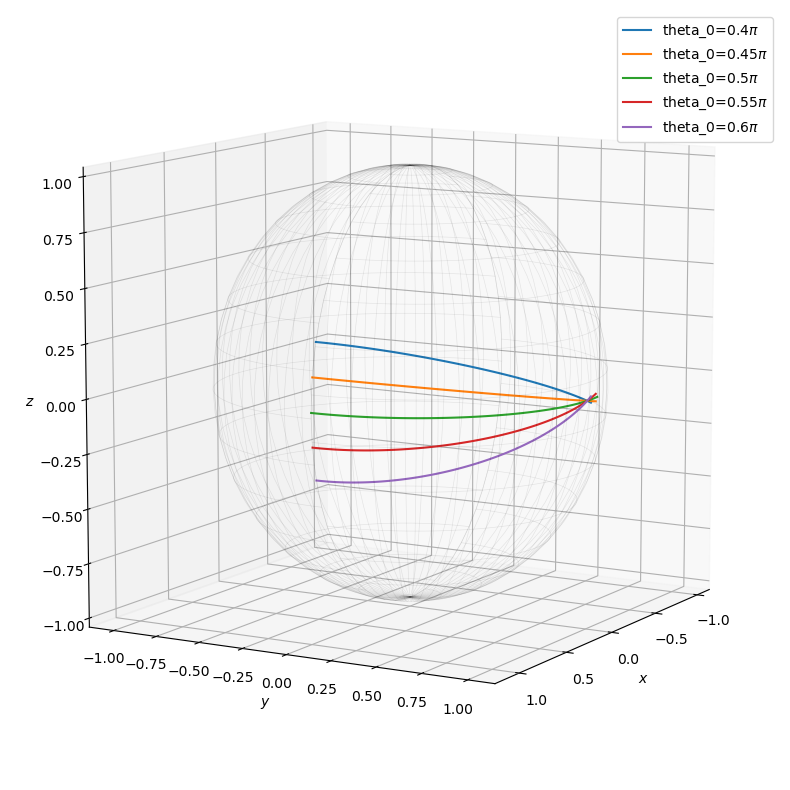

In [611]:
# We add a subplot to the figure which we tell to use the 3d projection 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# We set the scaling of the axis to equal
ax.set_aspect("equal") 
# Lastly we set the viewing angle from which we want to view our 3d scene.
ax.view_init(elev=10, azim=30, roll=0)

# Using numpy we make a grid that we use to plot the wireframe
theta_w, phi_w =  np.mgrid[0:2*np.pi : 60j ,0:np.pi : 60j]

# We set the radius of the wireframe sphere to 1 and calculate
# the cartesian coordinates
# r_w = 1
x_w = np.sin(theta_w) * np.cos(phi_w) #func_x(r_w, theta_w, phi_w)
y_w = np.sin(theta_w) * np.sin(phi_w) #func_y(r_w, theta_w, phi_w)
z_w = np.cos(theta_w) #func_z(r_w, theta_w, phi_w)

# # We plot the wireframe
ax.plot_wireframe(x_w,y_w,z_w, colors= [0,0,0,0.08], linewidths=[0.5])

plt.xlim(-1.1, 1.2)
plt.ylim(-1.1, 1.1)
ax.set_zlim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

# We will plot the theta and phi basis vectors at three positions
#V = [(1/2*sp.pi, 0), (1/3*sp.pi, 0), (1/6*sp.pi, 0)]

    # We plot the two basis vectors using a quiver
    #scale = 0.2
    #d_th_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*B_th["x"], scale*B_th["y"], scale*B_th["z"], color="black")
    #d_ph_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*B_ph["x"], scale*B_ph["y"], scale*B_ph["z"], color="black")
    #idot, = ax.plot(L["x"], L["y"], L["z"], "o", color="black")
    #d_ph_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*V["x"], scale*V["y"], scale*V["z"], color="red")
    
for offset in np.linspace(-0.1, 0.1, 5):#[-0.02, -0.01, 0, 0.01, 0.02]:
    curve_end = 1.7
    curve = getCurve(th_0 = (1/2+offset)*np.pi, ph_0 = 0, U_th_0 = 0, U_ph_0 = 1, curve_end = curve_end)
    x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = curve
    ax.plot(x_line, y_line, z_line, label = 'theta_0='+str((1/2+offset))+"$\pi$")

# x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = curve2
# ax.plot(x_line, y_line, z_line, label = "$\gamma_2$")

# x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = curve3
# ax.plot(x_line, y_line, z_line, label = "$\gamma_3$")

# x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = curve4
# ax.plot(x_line, y_line, z_line, label = "$\gamma_4$")

plt.legend()

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


MovieWriter ffmpeg unavailable; using Pillow instead.


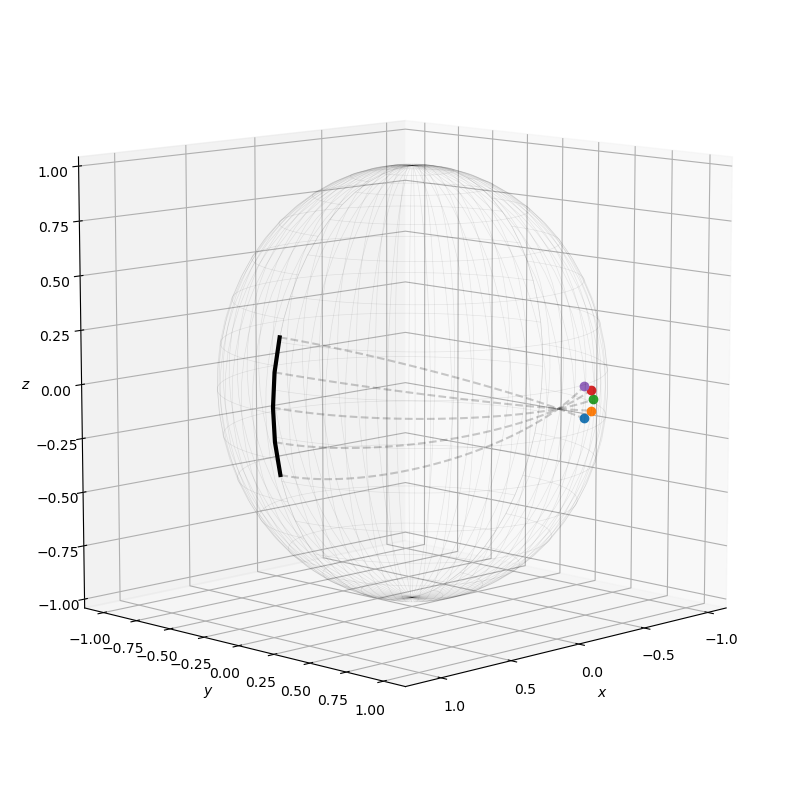

In [635]:
plt.close()
frames = 120

# We add a subplot to the figure which we tell to use the 3d projection 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# We set the scaling of the axis to equal
ax.set_aspect("equal") 
# Lastly we set the viewing angle from which we want to view our 3d scene.
ax.view_init(elev=10, azim=45, roll=0)

# Using numpy we make a grid that we use to plot the wireframe
theta_w, phi_w =  np.mgrid[0:2*np.pi : 60j ,0:np.pi : 60j]

# We set the radius of the wireframe sphere to 1 and calculate
# the cartesian coordinates
# r_w = 1
x_w = np.sin(theta_w) * np.cos(phi_w) #func_x(r_w, theta_w, phi_w)
y_w = np.sin(theta_w) * np.sin(phi_w) #func_y(r_w, theta_w, phi_w)
z_w = np.cos(theta_w) #func_z(r_w, theta_w, phi_w)

# # We plot the wireframe
ax.plot_wireframe(x_w,y_w,z_w, colors= [0,0,0,0.08], linewidths=[0.5])

plt.xlim(-1.1, 1.2)
plt.ylim(-1.1, 1.1)
ax.set_zlim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

# Plotting the starting line
theta_starts = [(1/2+offset)*np.pi for offset in np.linspace(-0.1, 0.1, 5)]
x = [np.sin(th) for th in theta_starts]
y = np.full(len(theta_starts), 0)
z = [np.cos(th) for th in theta_starts]
ax.plot(x, y, z, "k", linewidth=3)

curve_end = 1.9
# Calculating and plotting the curves
curves = []
#for offset in np.linspace(-0.1, 0.1, 5):#[-0.02, -0.01, 0, 0.01, 0.02]:
for th in theta_starts:
    curve = getCurve(th_0 = th, ph_0 = 0, U_th_0 = 0, U_ph_0 = 1, curve_end = curve_end, nr_points_curve = frames)
    curves.append(curve)
    x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = curve
    ax.plot(x_line, y_line, z_line, "k--", alpha=0.2)

dots = []
for c in curves:
    x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = c
    
    idot, = ax.plot(x_line[0], y_line[0], z_line[0], "o")
    dots.append(idot)
    
def update(frame):
    for ic, c in enumerate(curves):
        x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = c

        dots[ic].set_data([x_line[frame]], [y_line[frame]])
        dots[ic].set_3d_properties([z_line[frame]])
    
ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=30)

# # Lastly we add labels and a legend
# plt.xlabel("x")
# plt.ylabel("y")
# #plt.legend()

ani.save("Ch3_Geodesics_of_photons_in_a_2sphere.gif")

plt.show()
#ani


In [567]:
nr_points_curve = 100

# x_th_0, x_ph_0, k_th_0, k_ph_0
starting_values = [[1/8*np.pi, 0, 0, 1], \
                  [1/4*np.pi, 0, 0, 1], \
                  [1/2*np.pi, 0, 0, 1], \
                  [3/4*np.pi, 0, 0, 1], \
                  [7/8*np.pi, 0, 0, 1], \
                  ]

# starting_values = [\
#                   [1/2*np.pi, 0, 0.2, 1], \
#                   [1/2*np.pi, 0, 0.1, 1], \
#                   [1/2*np.pi, 0, 0, 1], \
#                   [1/2*np.pi, 0, -0.01, 0.001], \
#  #                 [1/2*np.pi, 0, -1, 1], \
#                   ]

starting_values = [\
                  [1/2*np.pi, 0, 0.1, 0.1], \
                  [1/2*np.pi, 1/2*np.pi, 0.1, 0], \
                  ]

curves = []

for s in starting_values:
    curves.append( getCurve(s[0], s[1], s[2], s[3], nr_points_curve = nr_points_curve) )

    
colors = ['red', 'blue', 'green', 'purple', 'orange']

The solver successfully reached the end of the integration interval.
Th 0.8345744603680209 2.3561483274045933 1.5707963267948966 0.8345744603680209
Uth -0.0983598724219681 0.1
Ph 0.0 4.2889030231064496
Uph 0.09855514087284702 0.19927754570721495
The solver successfully reached the end of the integration interval.
Th 1.5707963267948966 4.712388980384691 1.5707963267948966 4.712388980384691
Uth 0.1 0.1
Ph 1.5707963267948966 1.5707963267948966
Uph 0.0 0.0


In [568]:
def greatCircle(x_rot=0, y_rot = 0, z_rot=0):
    grC_new, grC_old = [], []

    for l in np.linspace(0, 2*np.pi, 50):

        th, pi = 1/2*sp.pi, l
        L, V, B_th, B_ph = vectorInCart(0, 0, th, pi)
        x, y, z = float(L["x"]), float(L["y"]), float(L["z"])
        x_old = [x, y, z]

        Rx = sp.Matrix([[1, 0, 0], \
                        [0, sp.cos(x_rot), -sp.sin(x_rot)], \
                        [0, sp.sin(x_rot), sp.cos(x_rot)]])
        x_new = Rx * sp.Matrix([x, y, z])
        
        Ry = sp.Matrix([[sp.cos(y_rot), 0, sp.sin(y_rot)], \
                      [0, 1, 0], \
                      [-sp.sin(y_rot), 0, sp.cos(y_rot)]])

    #     Rz = sp.Matrix([[sp.cos(z_rot), -sp.sin(z_rot), 0],\
    #                     [sp.sin(z_rot), sp.cos(z_rot), 0], \
    #                     [0,0,1]])

        #x_new = Ry * sp.Matrix([x, y, z])
    #    x_new = Rz * x_new

        #x_new, x_old = greatCircle(l, y_rot=-1/4*sp.pi)#1/2*sp.pi)
        grC_new.append(list(x_new))
        grC_old.append(list(x_old))
    #     print(x_new, x_old)
    #     ax.plot(x_old[0], x_old[1], x_old[2], "o", color="red")
    #     ax.plot(x_new[0], x_new[1], x_new[2], "o", color="blue")

    x_new, y_new, z_new = np.array(list(zip(*grC_new)))
    x_old, y_old, z_old = np.array(list(zip(*grC_old)))
    
    x_new = np.array([float(x) for x in x_new])
    y_new = np.array([float(y) for y in y_new])
    z_new = np.array([float(z) for z in z_new])

    r_new = np.sqrt(x_new**2 + y_new**2 + z_new**2)
    th_new = np.arccos(z_new/r_new)
    ph_new = np.arctan(y_new/x_new)
    

    return x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new
    

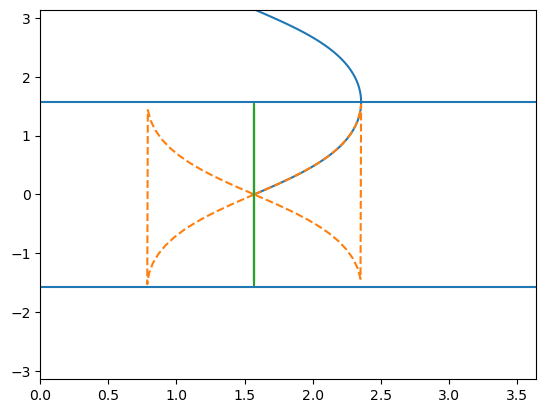

In [569]:
x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution = curves[0]
plt.plot(th_solution, ph_solution)
x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=-1/4*np.pi, y_rot = 0, z_rot=0)
plt.plot(th_new, ph_new, "--")
x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=0, y_rot = 0, z_rot=0)
plt.plot(th_new, ph_new)
# x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=0, y_rot = 1/4*np.pi, z_rot=0)
# plt.plot(th_new, ph_new)

plt.hlines([-1/2*np.pi, 1/2*np.pi], -10, 10)
#plt.vlines([0, 1/4*np.pi, 1/2*np.pi, 3/4*np.pi, np.pi], -10, 10)

plt.xlim(0, np.pi+0.5)
plt.ylim(-np.pi, np.pi)

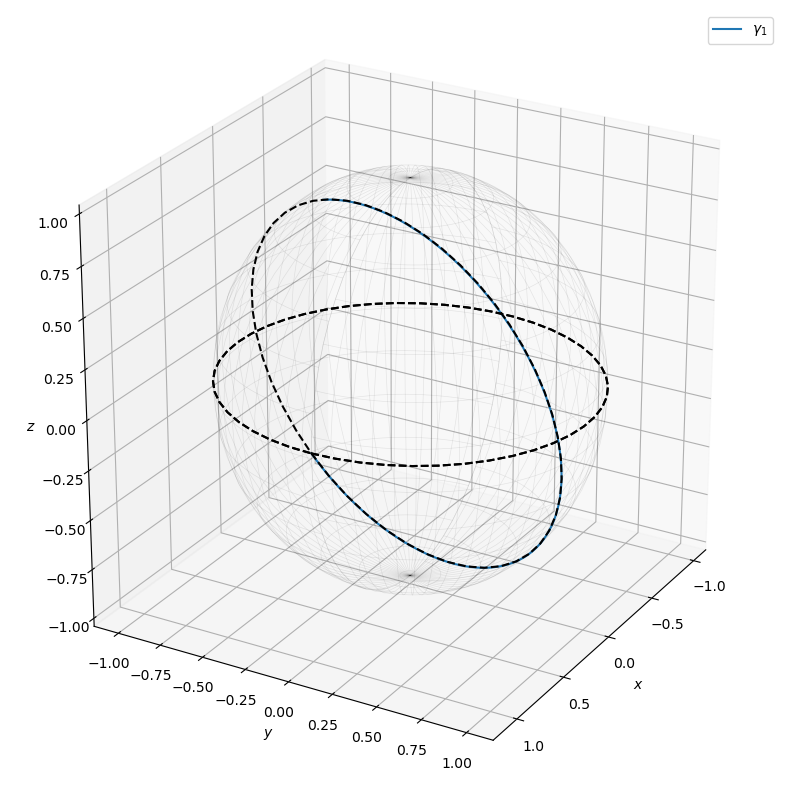

In [570]:
# We add a subplot to the figure which we tell to use the 3d projection 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# We set the scaling of the axis to equal
ax.set_aspect("equal") 
# Lastly we set the viewing angle from which we want to view our 3d scene.
ax.view_init(elev=25, azim=30, roll=0)

# Using numpy we make a grid that we use to plot the wireframe
theta_w, phi_w =  np.mgrid[0:2*np.pi : 60j ,0:np.pi : 60j]

# We set the radius of the wireframe sphere to 1 and calculate
# the cartesian coordinates
# r_w = 1
x_w = np.sin(theta_w) * np.cos(phi_w) #func_x(r_w, theta_w, phi_w)
y_w = np.sin(theta_w) * np.sin(phi_w) #func_y(r_w, theta_w, phi_w)
z_w = np.cos(theta_w) #func_z(r_w, theta_w, phi_w)

# # We plot the wireframe
ax.plot_wireframe(x_w,y_w,z_w, colors= [0,0,0,0.08], linewidths=[0.5])

plt.xlim(-1.1, 1.2)
plt.ylim(-1.1, 1.1)
ax.set_zlim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

# We will plot the theta and phi basis vectors at three positions
#V = [(1/2*sp.pi, 0), (1/3*sp.pi, 0), (1/6*sp.pi, 0)]

    # We plot the two basis vectors using a quiver
    #scale = 0.2
    #d_th_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*B_th["x"], scale*B_th["y"], scale*B_th["z"], color="black")
    #d_ph_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*B_ph["x"], scale*B_ph["y"], scale*B_ph["z"], color="black")
    #idot, = ax.plot(L["x"], L["y"], L["z"], "o", color="black")
    #d_ph_arrow = ax.quiver(L["x"], L["y"], L["z"], scale*V["x"], scale*V["y"], scale*V["z"], color="red")
x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution = curves[0]
ax.plot(x_line, y_line, z_line, label = "$\gamma_1$")


x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=0, y_rot = 0, z_rot=0)
ax.plot(x_new, y_new, z_new, "--", color="k")
x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=-1/4*np.pi, y_rot = 1/2*np.pi, z_rot=0)
ax.plot(x_new, y_new, z_new, "--", color="k")
x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(x_rot=0, y_rot = 1/4*np.pi, z_rot=0)
ax.plot(x_new, y_new, z_new, "--", color="k")


plt.legend()

[<mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f9ffb58ea60>, <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f9fd90fa100>]


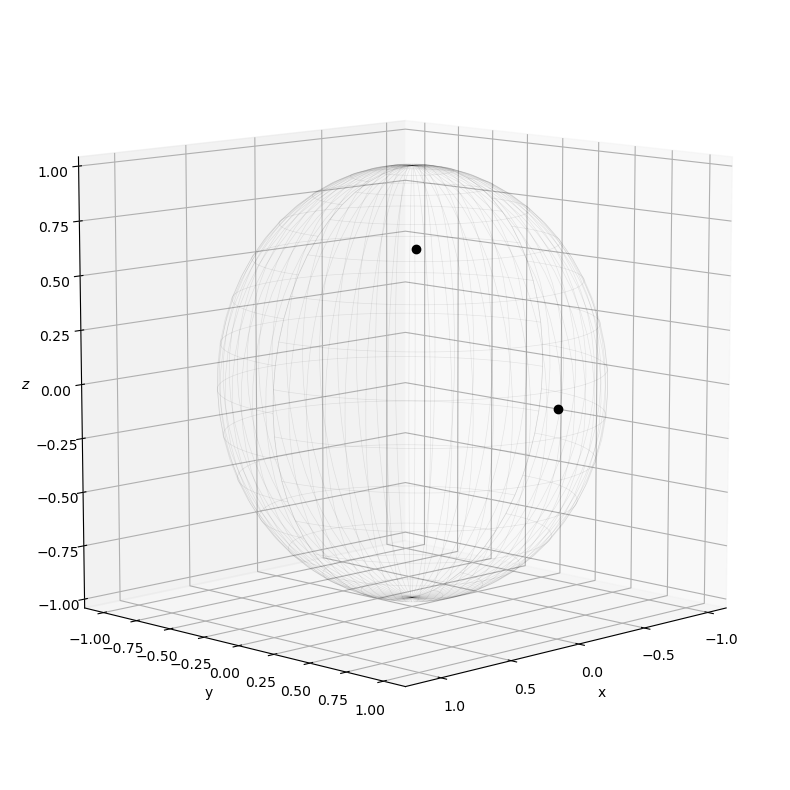

ValueError: too many values to unpack (expected 3)

In [530]:
plt.close()

x_new, y_new, z_new, x_old, y_old, z_old, r_new, th_new, ph_new = greatCircle(y_rot = -1/4*sp.pi)

frames = nr_points_curve

# We add a subplot to the figure which we tell to use the 3d projection 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# We set the scaling of the axis to equal
ax.set_aspect("equal") 
# Lastly we set the viewing angle from which we want to view our 3d scene.
ax.view_init(elev=10, azim=45, roll=0)

# Using numpy we make a grid that we use to plot the wireframe
theta_w, phi_w =  np.mgrid[0:2*np.pi : 60j ,0:np.pi : 60j]

# We set the radius of the wireframe sphere to 1 and calculate
# the cartesian coordinates
# r_w = 1
x_w = np.sin(theta_w) * np.cos(phi_w) #func_x(r_w, theta_w, phi_w)
y_w = np.sin(theta_w) * np.sin(phi_w) #func_y(r_w, theta_w, phi_w)
z_w = np.cos(theta_w) #func_z(r_w, theta_w, phi_w)

# # We plot the wireframe
ax.plot_wireframe(x_w,y_w,z_w, colors= [0,0,0,0.08], linewidths=[0.5])

plt.xlim(-1.1, 1.2)
plt.ylim(-1.1, 1.1)
ax.set_zlim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

#t_pts = 

# for l in np.linspace(0, 1, 10):
#     x, y, z = greatCircle(l)
#     plt.plot(x, y, z, "o")
# x, y, z = greatCircle(0.5)
# plt.plot(x, y, z, "o")
# x, y, z = greatCircle(1)
# plt.plot(x, y, z, "o")
#plt.plot(greatCircle(0.5))
#plt.plot(greatCircle(1))

dots = []
lines = []

for i, c in enumerate(curves):
    x_line, y_line, z_line, th_solution, U_th_solution, ph_solution, U_ph_solution  = c
    d, = ax.plot(x_line[0], y_line[0], z_line[0], "o", color="black")
    dots.append(d)
    
    l, = ax.plot(x_line[0], y_line[0], z_line[0], color=colors[i])
    lines.append(l)

print(list(lines))

def update(frame):
    for art in list(ax.lines):
        art.remove()

    ax.plot(x_new, y_new, z_new, ".-")
    ax.plot(x_old, y_old, z_old, ".-")
        
    for i, c in enumerate(curves):
        x_line, y_line, z_line  = c
        ax.plot(x_line[frame], y_line[frame], z_line[frame], "o", color="black")
        
#         tail_length = 20
#         if frame-tail_length > 0:
#             fr = frame-tail_length
#         else:
#             fr = 0
#         to = frame
#         ax.plot(x_line[fr:to], y_line[fr:to], z_line[fr:to], color=colors[i])

ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=100)

# Lastly we add labels and a legend
plt.xlabel("x")
plt.ylabel("y")

plt.show()
ani



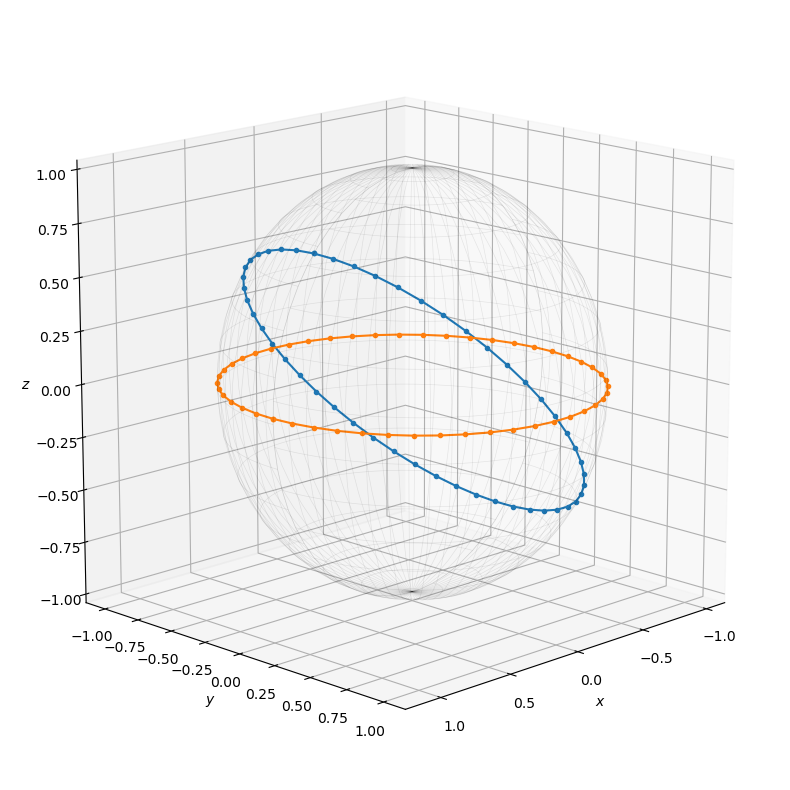

In [440]:
plt.close()
frames = nr_points_curve

# We add a subplot to the figure which we tell to use the 3d projection 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# We set the scaling of the axis to equal
ax.set_aspect("equal") 
# Lastly we set the viewing angle from which we want to view our 3d scene.
ax.view_init(elev=15, azim=45, roll=0)

# Using numpy we make a grid that we use to plot the wireframe
theta_w, phi_w =  np.mgrid[0:2*np.pi : 60j ,0:np.pi : 60j]

# We set the radius of the wireframe sphere to 1 and calculate
# the cartesian coordinates
# r_w = 1
x_w = np.sin(theta_w) * np.cos(phi_w) #func_x(r_w, theta_w, phi_w)
y_w = np.sin(theta_w) * np.sin(phi_w) #func_y(r_w, theta_w, phi_w)
z_w = np.cos(theta_w) #func_z(r_w, theta_w, phi_w)

# # We plot the wireframe
ax.plot_wireframe(x_w,y_w,z_w, colors= [0,0,0,0.08], linewidths=[0.5])

plt.xlim(-1.1, 1.2)
plt.ylim(-1.1, 1.1)
ax.set_zlim(-1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

# grC_new, grC_old = [], []
# for l in np.linspace(0, 2*np.pi, 50):
#     x_new, x_old = greatCircle(l, x_rot = 1/4*sp.pi, z_rot = 1/2*sp.pi)
#     grC_new.append(list(x_new))
#     grC_old.append(list(x_old))
# #     print(x_new, x_old)
# #     ax.plot(x_old[0], x_old[1], x_old[2], "o", color="red")
# #     ax.plot(x_new[0], x_new[1], x_new[2], "o", color="blue")

# x_new, y_new, z_new = list(zip(*grC_new))
# x_old, y_old, z_old = list(zip(*grC_old))


# ax.plot(x_new, y_new, z_new, ".-")
# ax.plot(x_old, y_old, z_old, ".-")



grC_new, grC_old = [], []
for l in np.linspace(0, 2*np.pi, 50):
    x_new, x_old = greatCircle(l, y_rot=-1/4*sp.pi)#1/2*sp.pi)
    grC_new.append(list(x_new))
    grC_old.append(list(x_old))
#     print(x_new, x_old)
#     ax.plot(x_old[0], x_old[1], x_old[2], "o", color="red")
#     ax.plot(x_new[0], x_new[1], x_new[2], "o", color="blue")

x_new, y_new, z_new = list(zip(*grC_new))
x_old, y_old, z_old = list(zip(*grC_old))


ax.plot(x_new, y_new, z_new, ".-")
ax.plot(x_old, y_old, z_old, ".-")